# Data Loading

### Importing Libraries

In [6]:
!pip install rasterio

In [7]:
!pip install geopandas

In [8]:
!pip install lightgbm

In [9]:
!pip install shap

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio as rio
import shap

### Loading the Patches

In [2]:
base_dir = r"C:\Users\vish\Documents\patches"
patch_dir = sorted([patch for patch in glob.glob(os.path.join(base_dir,"256_50_*")) if os.path.isdir(patch)])

In [3]:
def load_patches(patch_dir):
    
    modalities = {}

    for tif_path in glob.glob(os.path.join(patch_dir,"*.tif")):
        base_name = os.path.basename(tif_path) # Returns the file name with extension
        key = os.path .splitext(base_name)[0] # Removes .tiff extension 

        if "geology" in key.lower():
            continue

        with rio.open(tif_path) as src:
            modalities[key] = {
                "array" : src.read(1), # Sets the bands as the keys
                "crs" : src.crs,
                "transform" : src.transform,
                "res" : src.res,
                "shp" : src.shape
            }
            
    return modalities

In [4]:
%%time

patch_data = {os.path.basename(p): load_patches(p) for p in patch_dir} # Load all patches

print("Loaded Patches: ", list(patch_data.keys()))
print("\nNumber of Loaded Modalities:",len(list(patch_data.keys())))
print("\n")

Loaded Patches:  ['256_50_19680', '256_50_19681', '256_50_19682', '256_50_19683', '256_50_19684', '256_50_19685', '256_50_19686', '256_50_19687', '256_50_19688', '256_50_19689', '256_50_19690', '256_50_19691', '256_50_19692', '256_50_19693', '256_50_19694', '256_50_19695', '256_50_19696', '256_50_19697', '256_50_19698', '256_50_19699', '256_50_19700', '256_50_19701', '256_50_19702', '256_50_19703', '256_50_19704', '256_50_19705', '256_50_19706', '256_50_19707', '256_50_19708', '256_50_19709', '256_50_19710', '256_50_19711', '256_50_19712', '256_50_19713', '256_50_19714', '256_50_19715', '256_50_19716', '256_50_19717', '256_50_19718', '256_50_19719', '256_50_19720', '256_50_19749', '256_50_19750', '256_50_19751', '256_50_19752', '256_50_19753', '256_50_19754', '256_50_19755', '256_50_19756', '256_50_19757', '256_50_19758', '256_50_19759', '256_50_19760', '256_50_19761', '256_50_19762', '256_50_19763', '256_50_19764', '256_50_19765', '256_50_19766', '256_50_19767', '256_50_19768', '256_5

In [5]:
not_tally = []

for p in patch_data.keys():
    total = len(patch_data[p].keys())
    
    if total == 37:    
        pass

    else:
        not_tally.append(p)

if len(not_tally) == 0:
    print("All modalities are loaded correctly.")
    
else:
    print("Please check the missing modalities for the following patches:\n", not_tally)

All modalities are loaded correctly.


### Label Extraction

In [6]:
num_row = len(list(patch_data.keys()))

In [7]:
areas = pd.read_csv(r"C:\Users\vish\Documents\patches\areas.csv") 
areas.head()

,patch_id,af1,Qal,Qaf,Qat,Qc,Qca,Qr
0,256_50_19680,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000
1,256_50_19681,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000
2,256_50_19682,0.0,0.000240,0.0,0.0,0.0,0.0,0.999760
3,256_50_19683,0.0,0.016087,0.0,0.0,0.0,0.0,0.983913
4,256_50_19684,0.0,0.029832,0.0,0.0,0.0,0.0,0.970168


In [8]:
areas["dominant"] = areas.iloc[:,1:].idxmax(axis=1)

In [9]:
areas.head()

,patch_id,af1,Qal,Qaf,Qat,Qc,Qca,Qr,dominant
0,256_50_19680,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,Qr
1,256_50_19681,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,Qr
2,256_50_19682,0.0,0.000240,0.0,0.0,0.0,0.0,0.999760,Qr
3,256_50_19683,0.0,0.016087,0.0,0.0,0.0,0.0,0.983913,Qr
4,256_50_19684,0.0,0.029832,0.0,0.0,0.0,0.0,0.970168,Qr


In [10]:
target = areas[["patch_id","dominant"]][:num_row]

In [11]:
target.head()

,patch_id,dominant
0,256_50_19680,Qr
1,256_50_19681,Qr
2,256_50_19682,Qr
3,256_50_19683,Qr
4,256_50_19684,Qr


# Data Preprocessing

### Checking CRS, Resolution and Dimension Consistency

In [12]:
aligned_patches = [] # Initializing empty array to store aligned patches

for patch_name, modalities in patch_data.items():

    dem_name = None
    for name, m in modalities.items():
        if 'dem' in name.lower():
            dem_name = name
            break

    ref_crs = modalities[dem_name]["crs"]
    ref_res = modalities[dem_name]["res"]
    ref_shp = modalities[dem_name]["shp"]
    
    crs_mismatch = False
    res_mismatch = False
    shp_mismatch = False

    for name, m in modalities.items():
        crs_match = m['crs'] == ref_crs
        res_match = np.allclose(m['res'], ref_res)
        shp_match = np.allclose(m['shp'], ref_shp)

        if not crs_match:
            print(f"CRS Mismatch: Patch {patch_name}, Modality {name}")
            crs_mismatch = True
            
        if not res_match:
            print(f"RES Mismatch: Patch {patch_name}, Modality {name}")
            res_mismatch = True

        if not shp_match:
            print(f"Shape Mismatch: Patch {patch_name}, Modality {name}")
            shp_mismatch = False
            
    if not crs_mismatch and not res_mismatch and not shp_mismatch:
        aligned_patches.append(patch_name)

print(f"Total aligned patches:",len(aligned_patches), "patches") 

Total aligned patches: 3491 patches


# Feature Extraction

## Statistical Extraction

In [42]:
feature_rows = []

for patch_name, patch_modalities in patch_data.items():
    
    for modality_name, modality_info in patch_modalities.items():
        
        clean_modality = modality_name.replace(f"{patch_name}_", "")

        if 'array'  not in modality_info:
            continue
            
        array_data = modality_info['array']
        flat_data = array_data.flatten()
        
        # Calculate statistics
        stats = {
            'patch_name' : patch_name,
            'modality' : clean_modality,
            'min': np.min(flat_data),
            'max': np.max(flat_data),
            'mean': np.mean(flat_data),
            'median': np.median(flat_data),
            'std': np.std(flat_data)
        }

        feature_rows.append(stats)

df_features = pd.DataFrame(feature_rows)   

In [43]:
df_features.head()

,patch_name,modality,min,max,mean,median,std
0,256_50_19680,aerialb,37.917019,254.000000,112.917229,116.273880,19.342129
1,256_50_19680,aerialg,25.560099,254.000000,128.100800,132.914948,20.855589
2,256_50_19680,aerialnir,17.678461,251.886948,141.120941,138.660721,15.639533
3,256_50_19680,aerialr,10.673157,254.000000,137.806610,144.756180,26.947426
4,256_50_19680,dem,579.375427,607.863525,594.494934,594.850281,5.686512


In [44]:
df_wide = df_features.pivot_table(
    index='patch_name',
    columns='modality',
    values=['min', 'max', 'mean', 'median', 'std']
    )

In [45]:
df_final = pd.concat([df_wide.reset_index(drop=True), target['dominant'].reset_index(drop=True)], axis=1)

In [46]:
print('Dimensions of Final Dataframe:',df_wide.shape)

Dimensions of Final Dataframe: (3491, 185)


In [47]:
df_final.head(20)

,"(max, aerialb)","(max, aerialg)","(max, aerialnir)","(max, aerialr)","(max, dem)","(max, ep_101x101)","(max, ep_11x11)","(max, ep_201x201)","(max, ep_21x21)","(max, ep_51x51)",...,"(std, slope_20)","(std, slope_200)","(std, slope_50)","(std, stdslope_101x101)","(std, stdslope_11x11)","(std, stdslope_201x201)","(std, stdslope_21x21)","(std, stdslope_51x51)","(std, stdslope_5x5)",dominant
0,254.000000,254.000000,251.886948,254.000000,607.863525,99.949532,97.766006,99.982536,99.387047,99.896072,...,1.313695,0.154861,0.784837,0.392000,0.650156,0.347562,0.629556,0.560714,0.617516,Qr
1,179.354980,184.794876,181.143143,187.036789,612.207397,99.936661,98.326630,99.381905,99.540863,99.896072,...,1.074428,0.231397,0.624649,0.371247,0.731343,0.231987,0.693753,0.539223,0.673334,Qr
2,186.625687,192.625687,181.143143,192.243988,619.234863,99.936661,98.326630,99.411621,99.540863,99.894516,...,1.503846,0.226106,0.769687,0.450853,0.721797,0.345136,0.748117,0.593542,0.615070,Qr
3,186.625687,192.625687,174.759613,192.243988,619.234863,99.954376,98.046318,99.411621,99.463951,99.894516,...,1.716199,0.250706,0.853136,0.464165,0.767639,0.311017,0.831697,0.649291,0.622556,Qr
4,217.406570,215.984299,176.378021,206.562042,618.373413,99.954376,97.771820,97.957039,99.388634,99.837120,...,1.765376,0.217089,0.958067,0.406989,0.924441,0.234916,0.901295,0.645161,0.793616,Qr
5,254.000000,254.000000,235.397491,253.100723,620.243896,99.970955,97.605423,99.981384,99.342987,99.888603,...,1.811699,0.118955,0.943229,0.364841,0.968517,0.216766,0.952191,0.626562,0.806126,Qr
6,254.000000,254.000000,235.397491,253.100723,620.259277,99.970955,97.900398,99.989082,99.342987,99.888603,...,1.705045,0.116723,0.929312,0.316067,0.978230,0.155258,0.991416,0.697807,0.760800,Qr
7,229.032242,231.525177,194.502228,229.025116,620.259277,99.957878,97.900398,99.989082,99.318527,99.873657,...,1.803287,0.150256,0.932161,0.388283,0.897892,0.149697,0.937894,0.736939,0.686918,Qr
8,148.309128,158.718277,173.630325,189.271347,609.855713,99.957878,97.525131,99.906395,99.318527,99.873657,...,2.002568,0.090235,0.839434,0.478379,0.894927,0.354528,1.020864,0.859855,0.643183,Qr
9,135.479614,158.718277,160.675766,189.271347,609.337158,99.970001,97.706017,99.906395,99.306114,99.882347,...,3.069883,0.080175,0.999477,1.398392,1.492181,1.028783,1.816028,1.767956,0.984956,Qr


## Feature Fusion

In [48]:
X = df_final.drop(columns=['dominant'], errors='ignore').values
y = df_final['dominant'] 

print("X shape:", X.shape)

X shape: (3491, 185)


In [49]:
y.shape

(3491,)

# Model Implementation

## Model Preparation

In [50]:
from sklearn.model_selection import train_test_split

# Stratified split 
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.3,      
    stratify = y,          
    random_state = 42      
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2443, 185)
X_test shape: (1048, 185)
y_train shape: (2443,)
y_test shape: (1048,)


## Model Training

In [51]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Baseline Model Training
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,          
    max_depth=10,              
    min_samples_split=50,      
    min_samples_leaf=20,       
    max_features="sqrt",       
    bootstrap=True,            
    n_jobs=-1,                 
    class_weight="balanced_subsample",         
    random_state=42,
    verbose=1                 
)

lgb = LGBMClassifier(
    num_leaves=200,
    learning_rate=0.05,
    n_estimators=500,
    #class_weight="balanced",
    objective="multiclass",
    num_class=5,
    random_state=42
)

models = {'Random Forest': rf, 'LightGBM': lgb}

predictions_dict = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    predictions_dict[name] = preds
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted')
    print(f"{name} | Accuracy: {acc:.3f} | F1: {f1:.3f}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


Random Forest | Accuracy: 0.964 | F1: 0.967
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45286
[LightGBM] [Info] Number of data points in the train set: 2443, number of used features: 181
[LightGBM] [Info] Start training from score -4.856543
[LightGBM] [Info] Start training from score -3.279193
[LightGBM] [Info] Start training from score -3.657847
[LightGBM] [Info] Start training from score -0.077420
[LightGBM] [Info] Start training from score -5.721541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

## Model Evaluation

In [52]:
print("\nClassification Report (Best Model)")
best_model = max(models.items(), key=lambda x: accuracy_score(y_test, x[1].predict(X_test)))[1]
print(classification_report(y_test, best_model.predict(X_test)))


Classification Report (Best Model)
              precision    recall  f1-score   support

         Qal       1.00      0.89      0.94         9
          Qc       0.86      0.92      0.89        39
         Qca       0.78      0.78      0.78        27
          Qr       0.99      0.99      0.99       970
         af1       1.00      0.67      0.80         3

    accuracy                           0.98      1048
   macro avg       0.93      0.85      0.88      1048
weighted avg       0.98      0.98      0.98      1048



[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [75]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, cohen_kappa_score
)

import seaborn as sns
import matplotlib.pyplot as plt
def evaluate_model(model, X_test, y_test, model_name):

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    kappa = cohen_kappa_score(y_test, y_pred)

    labels = sorted(np.unique(np.concatenate((y_test, y_pred))))
    cm = confusion_matrix(y_test, y_pred, labels=labels)

    print(f"\n{model_name} Performance:")
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1-score:  {f1:.3f}")
    print(f"Cohen’s Kappa: {kappa:.3f}")

    plt.figure(figsize=(7,5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels
    )
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted class')
    plt.ylabel('Actual class')
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'kappa': kappa,
        'confusion_matrix': cm,
        'labels': labels
    }


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished



Random Forest Performance:
Accuracy:  0.964
Precision: 0.973
Recall:    0.964
F1-score:  0.967
Cohen’s Kappa: 0.779


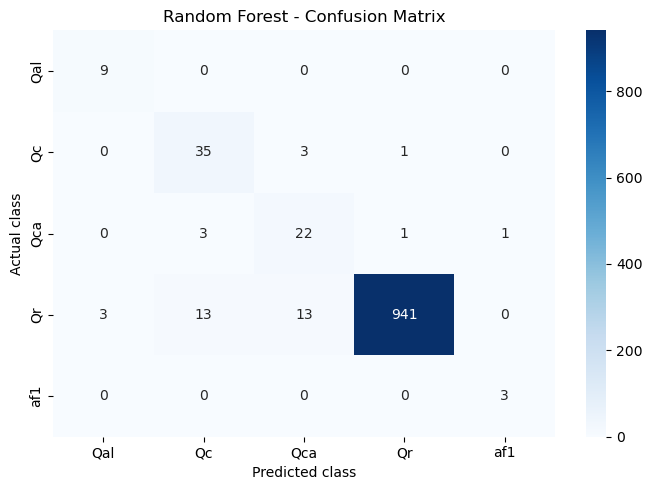


LightGBM Performance:
Accuracy:  0.984
Precision: 0.984
Recall:    0.984
F1-score:  0.984
Cohen’s Kappa: 0.886


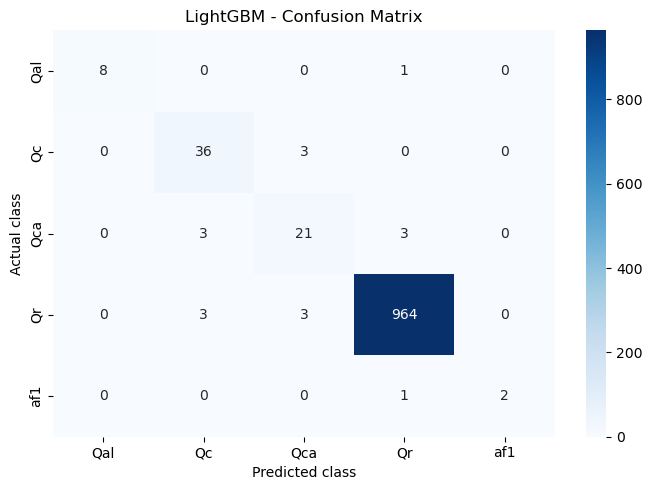

In [76]:
rf_metrics = evaluate_model(rf, X_test, y_test, "Random Forest")
lgbm_metrics = evaluate_model(lgb, X_test, y_test, "LightGBM")

# SHAP Additive

## SHAP Feature Importance - Random Forest

In [55]:
explainer_rf = shap.TreeExplainer(models['Random Forest'])
explainer_lgb = shap.TreeExplainer(models['LightGBM'])

In [56]:
shap_values_rf = explainer_rf(X_test)
shap_values_lgb = explainer_lgb(X_test)

In [57]:
# Feature names
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'feat_{i}' for i in range(X_test.shape[1])]

# Patch IDs from your dictionary
patch_id = list(patch_data.keys())[:X_test.shape[0]]  

# Predicted classes
y_pred_rf = models['Random Forest'].predict(X_test)

# Shap_values_rf.values is 3D: (n_samples, n_features, n_classes)
shap_values_mean = np.abs(shap_values_rf.values).mean(axis=2)  # shape: (n_samples, n_features)

# Convert to DataFrame
shap_df_rf = pd.DataFrame(shap_values_mean, columns=feature_names)
shap_df_rf['patch_id'] = patch_id

# Determine top 3 features per patch
top_features_rf = shap_df_rf.set_index('patch_id').apply(lambda row: row.nlargest(3).index.tolist(), axis=1)
top_features_rf = top_features_rf.reset_index().rename(columns={0:'Top 3 Features'})

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [58]:
top_features_rf.head()

,patch_id,Top 3 Features
0,256_50_19680,"[feat_61, feat_66, feat_27]"
1,256_50_19681,"[feat_66, feat_61, feat_154]"
2,256_50_19682,"[feat_66, feat_61, feat_154]"
3,256_50_19683,"[feat_99, feat_66, feat_100]"
4,256_50_19684,"[feat_99, feat_102, feat_100]"


## Mapping Feature Names to Modalities

In [59]:
# Drop target column
feature_cols = df_final.columns.drop('dominant')

# FLatten columns to str
feature_names = [
    f"{stat}_{mod}" if isinstance(col, tuple) else col
    for col, (stat, mod) in zip(feature_cols, feature_cols)
] if isinstance(feature_cols[0], tuple) else feature_cols.tolist()

print("Feature names sample:", feature_names[:5])

Feature names sample: ['max_aerialb', 'max_aerialg', 'max_aerialnir', 'max_aerialr', 'max_dem']


## SHAP Importance (By Predicted Class)

In [60]:
top_features_list = []
for i in range(shap_values_rf.values.shape[0]):
    # indices of top 3 features
    top_idx = np.argsort(np.abs(shap_values_rf.values[i]))[-3:][::-1]
    # map indices to actual column names
    top_feats = [df_final.columns[j] for j in top_idx]
    top_features_list.append(top_feats)

# Create DataFrame
top_features_rf = pd.DataFrame({
    'patch_id': patch_id,
    'Top 3 Features': top_features_list
})

In [61]:
# Ensure Top 3 Features are lists and only top 3
top_features_rf['Top 3 Features'] = top_features_rf['Top 3 Features'].apply(lambda idx: list(idx[:3]))

# Define modalities
modalities = ['aerial', 'dem', 'ep', 'nhd', 'osm', 'procurve', 'plancurve', 'slope', 'stdslope']  

# Function to map a feature name to its modality
def map_feature_to_modality(feature_name):
    # If feature is a tuple, take the second element (e.g., 'aerialb', 'dem')
    if isinstance(feature_name, tuple):
        feature_str = feature_name[1]
    else:
        feature_str = str(feature_name)
    # Scan through modalities
    for mod in modalities:
        if mod in feature_str.lower():
            return mod
    return 'other'

# Create Top 3 Modalities column
top_features_rf['Top 3 Modalities'] = top_features_rf['Top 3 Features'].apply(
    lambda features: [map_feature_to_modality(f) for f in features]
)

# Inspect the first few rows
print(top_features_rf[['Top 3 Features', 'Top 3 Modalities']].head())


                                      Top 3 Features          Top 3 Modalities
0  [[(max, aerialb), (max, aerialg), (max, aerial...  [aerial, aerial, aerial]
1  [[(max, aerialb), (max, aerialg), (max, aerial...  [aerial, aerial, aerial]
2  [[(max, aerialb), (max, aerialg), (max, aerial...  [aerial, aerial, aerial]
3  [[(max, aerialb), (max, aerialnir), (max, aeri...  [aerial, aerial, aerial]
4  [[(max, aerialb), (max, aerialr), (max, aerial...  [aerial, aerial, aerial]


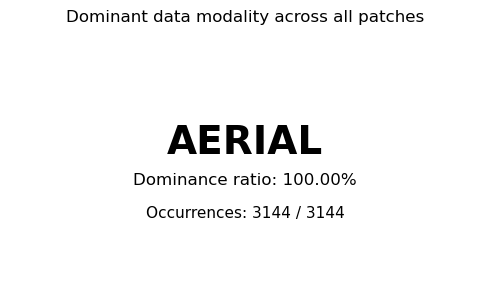

  Dominant modality  Occurrences  Total top-modality slots  Dominance ratio
0            aerial         3144                      3144              1.0


In [83]:
from collections import Counter

all_modalities = [mod for mods in top_features_rf['Top 3 Modalities'] for mod in mods]
modality_counts = Counter(all_modalities)

dominant_modality, dominant_count = modality_counts.most_common(1)[0]
total = sum(modality_counts.values())
dominance_ratio = dominant_count / total

plt.figure(figsize=(5,3))
plt.text(0.5, 0.55, dominant_modality.upper(), fontsize=28, ha='center', va='center', weight='bold')
plt.text(0.5, 0.38, f"Dominance ratio: {dominance_ratio:.2%}", fontsize=12, ha='center')
plt.text(0.5, 0.25, f"Occurrences: {dominant_count} / {total}", fontsize=11, ha='center')
plt.axis("off")
plt.title("Dominant data modality across all patches")
plt.tight_layout()
plt.show()

dominance_df = pd.DataFrame([{
    "Dominant modality": dominant_modality,
    "Occurrences": dominant_count,
    "Total top-modality slots": total,
    "Dominance ratio": dominance_ratio
}])

print(dominance_df)


## RF - SHAP Importance (Across Modalities)

In [63]:
from collections import defaultdict

feature_names = df_final.columns[:-1]  # exclude target 'dominant' if present

# Convert SHAP values to absolute and mean across samples
mean_abs_shap = np.mean(np.abs(shap_values_rf.values), axis=0)  # shape: (num_features, num_classes)
total_shap_per_feature = mean_abs_shap.sum(axis=1)             # sum across classes

# Map features to modalities
feature_to_modality = {feat: map_feature_to_modality(feat) for feat in feature_names}

# Aggregate SHAP values by modality
modality_shap = defaultdict(float)
for feat, shap_val in zip(feature_names, total_shap_per_feature):
    mod = feature_to_modality.get(feat, 'other')
    modality_shap[mod] += shap_val

# Convert to DataFrame for plotting
modality_importance_df = pd.DataFrame({
    'Modality': list(modality_shap.keys()),
    'SHAP Importance': list(modality_shap.values())
}).sort_values('SHAP Importance', ascending=False)


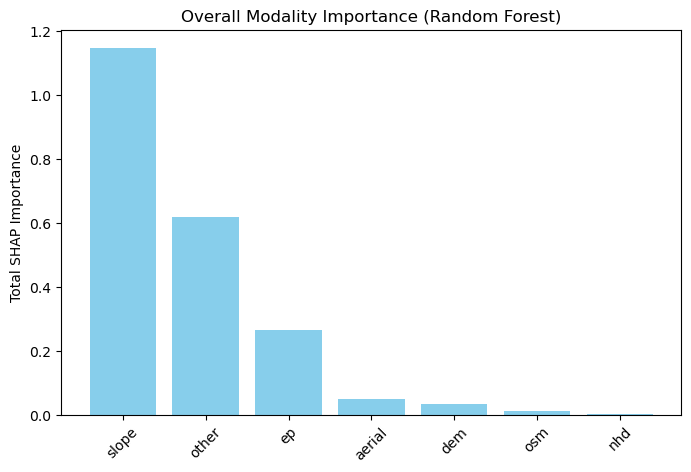

  Modality  SHAP Importance
6    slope         1.146884
5    other         0.618967
2       ep         0.263638
0   aerial         0.048088
1      dem         0.034448
4      osm         0.009845
3      nhd         0.002927


In [64]:
# Plot overall modality importance 
plt.figure(figsize=(8,5))
plt.bar(modality_importance_df['Modality'], modality_importance_df['SHAP Importance'], color='skyblue')
plt.ylabel('Total SHAP Importance')
plt.title('Overall Modality Importance (Random Forest)')
plt.xticks(rotation=45)
plt.show()

# Print table for reference
print(modality_importance_df)

## SHAP Feature Importance - LGBM

In [65]:
top_features_list_lgb = []
for i in range(shap_values_lgb.values.shape[0]):
    # indices of top 3 features
    top_idx_lgb = np.argsort(np.abs(shap_values_lgb.values[i]))[-3:][::-1]
    # map indices to actual column names
    top_feats_lgb = [df_final.columns[j] for j in top_idx]
    top_features_list_lgb.append(top_feats)

# Create DataFrame
top_features_lgb = pd.DataFrame({
    'patch_id': patch_id,
    'Top 3 Features': top_features_list_lgb
})

In [66]:
# Ensure Top 3 Features are lists and only top 3
top_features_lgb['Top 3 Features'] = top_features_lgb['Top 3 Features'].apply(lambda idx: list(idx[:3]))

# Define modalities
modalities = ['aerial', 'dem', 'ep', 'nhd', 'osm', 'procurve', 'plancurve', 'slope', 'stdslope']  

# Function to map a feature name to its modality
def map_feature_to_modality(feature_name):
    # If feature is a tuple, take the second element (e.g., 'aerialb', 'dem')
    if isinstance(feature_name, tuple):
        feature_str = feature_name[1]
    else:
        feature_str = str(feature_name)
    # Scan through modalities
    for mod in modalities:
        if mod in feature_str.lower():
            return mod
    return 'other'

# Create Top 3 Modalities column
top_features_lgb['Top 3 Modalities'] = top_features_lgb['Top 3 Features'].apply(
    lambda features: [map_feature_to_modality(f) for f in features]
)

# Inspect the first few rows
print(top_features_lgb[['Top 3 Features', 'Top 3 Modalities']].head())


                                      Top 3 Features          Top 3 Modalities
0  [[(max, aerialb), (max, aerialg), (max, aerial...  [aerial, aerial, aerial]
1  [[(max, aerialb), (max, aerialg), (max, aerial...  [aerial, aerial, aerial]
2  [[(max, aerialb), (max, aerialg), (max, aerial...  [aerial, aerial, aerial]
3  [[(max, aerialb), (max, aerialg), (max, aerial...  [aerial, aerial, aerial]
4  [[(max, aerialb), (max, aerialg), (max, aerial...  [aerial, aerial, aerial]


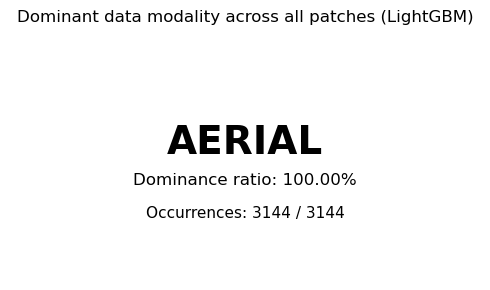

  Dominant modality  Occurrences  Total slots  Dominance ratio
0            aerial         3144         3144              1.0


In [84]:
from collections import Counter

all_modalities = [mod for mods in top_features_lgb['Top 3 Modalities'] for mod in mods]
modality_counts = Counter(all_modalities)

dominant_modality, dominant_count = modality_counts.most_common(1)[0]
total = sum(modality_counts.values())
dominance_ratio = dominant_count / total

plt.figure(figsize=(5,3))
plt.text(0.5, 0.55, dominant_modality.upper(), fontsize=28, ha='center', va='center', weight='bold')
plt.text(0.5, 0.38, f"Dominance ratio: {dominance_ratio:.2%}", fontsize=12, ha='center')
plt.text(0.5, 0.25, f"Occurrences: {dominant_count} / {total}", fontsize=11, ha='center')
plt.axis("off")
plt.title("Dominant data modality across all patches (LightGBM)")
plt.tight_layout()
plt.show()

dominance_df_lgb = pd.DataFrame([{
    "Dominant modality": dominant_modality,
    "Occurrences": dominant_count,
    "Total slots": total,
    "Dominance ratio": dominance_ratio
}])

print(dominance_df_lgb)


## LGBM -  SHAP Importance (Across Modalities)

In [68]:
feature_names = df_final.columns[:-1]  # exclude target 'dominant' if present

# Convert SHAP values to absolute and mean across samples
mean_abs_shap = np.mean(np.abs(shap_values_lgb.values), axis=0)  # shape: (num_features, num_classes)
total_shap_per_feature = mean_abs_shap.sum(axis=1)             # sum across classes

# Map features to modalities
feature_to_modality = {feat: map_feature_to_modality(feat) for feat in feature_names}

# Aggregate SHAP values by modality
modality_shap = defaultdict(float)
for feat, shap_val in zip(feature_names, total_shap_per_feature):
    mod = feature_to_modality.get(feat, 'other')
    modality_shap[mod] += shap_val

# Convert to DataFrame for plotting
modality_importance_df = pd.DataFrame({
    'Modality': list(modality_shap.keys()),
    'SHAP Importance': list(modality_shap.values())
}).sort_values('SHAP Importance', ascending=False)


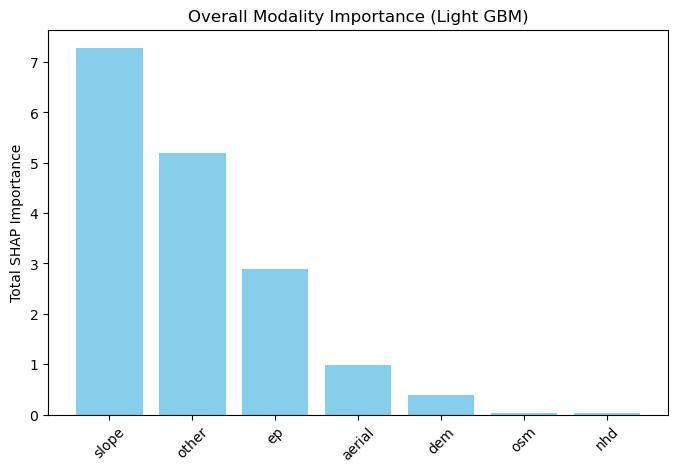

  Modality  SHAP Importance
6    slope         7.277497
5    other         5.196702
2       ep         2.884882
0   aerial         0.978997
1      dem         0.392381
4      osm         0.029754
3      nhd         0.026641


In [69]:
# Plot overall modality importance 
plt.figure(figsize=(8,5))
plt.bar(modality_importance_df['Modality'], modality_importance_df['SHAP Importance'], color='skyblue')
plt.ylabel('Total SHAP Importance')
plt.title('Overall Modality Importance (Light GBM)')
plt.xticks(rotation=45)
plt.show()

# Print table for reference
print(modality_importance_df)

# Visualizing a Raster Map

C:\Users\vish\AppData\Local\Temp\ipykernel_30556\926848729.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_list = plt.cm.get_cmap('Accent', len(classes)).colors


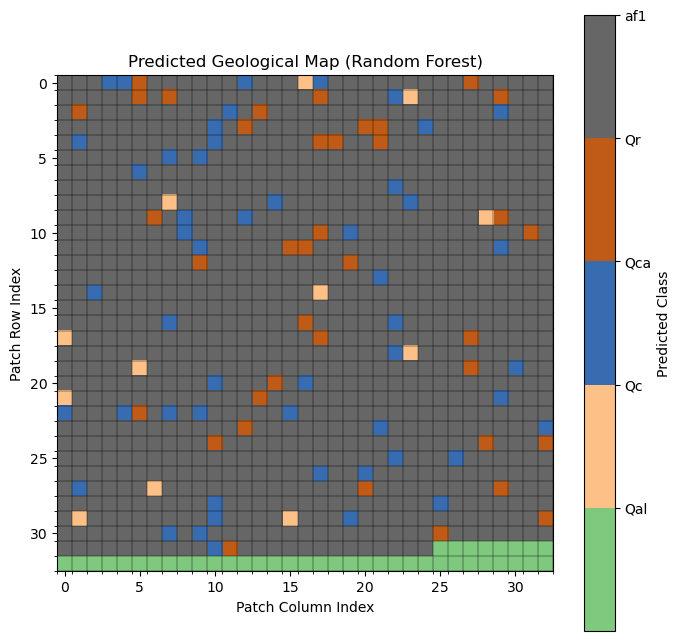

C:\Users\vish\AppData\Local\Temp\ipykernel_30556\926848729.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_list = plt.cm.get_cmap('Accent', len(classes)).colors


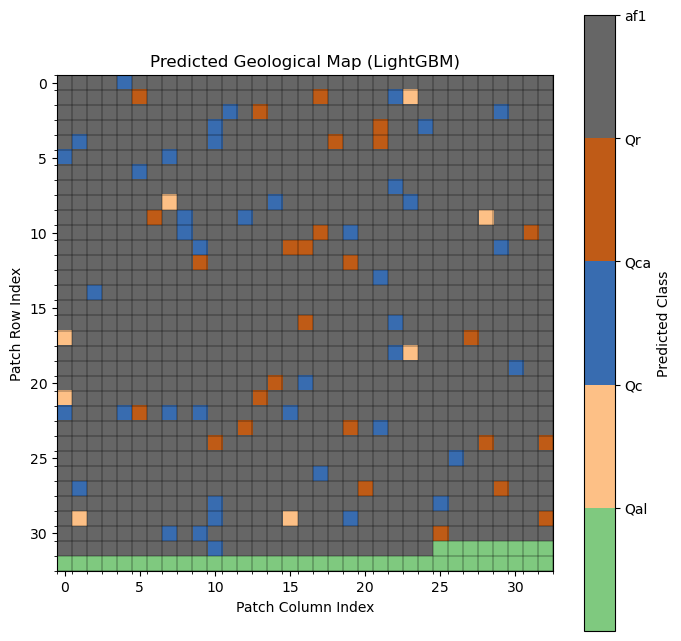

In [85]:
import matplotlib.colors as mcolors

# Raster creation function
def create_raster_map(patch_ids, predicted_classes, title="Geological Map"):
    num_patches = len(predicted_classes)
    grid_size = int(np.ceil(np.sqrt(num_patches)))  # square layout for demonstration
    
    raster_map = np.full((grid_size, grid_size), fill_value='nodata', dtype=object)
    for idx, val in enumerate(predicted_classes):
        r = idx // grid_size
        c = idx % grid_size
        raster_map[r, c] = val
    
    # Color mapping
    classes = np.unique([v for v in raster_map.flatten() if v != 'nodata'])
    colors_list = plt.cm.get_cmap('Accent', len(classes)).colors
    cmap = mcolors.ListedColormap(colors_list)
    
    # Map class labels to integers
    class_to_int = {cls: i for i, cls in enumerate(classes)}
    int_raster = np.full(raster_map.shape, fill_value=-1, dtype=int)
    for r in range(grid_size):
        for c in range(grid_size):
            val = raster_map[r, c]
            if val != 'nodata':
                int_raster[r, c] = class_to_int[val]
    
    # Plot
    plt.figure(figsize=(8, 8))
    im = plt.imshow(int_raster, cmap=cmap, interpolation='none')
    
    # Draw grid lines to show patch boundaries
    ax = plt.gca()
    ax.set_xticks(np.arange(-0.5, int_raster.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, int_raster.shape[0], 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=0.3)

    plt.xlabel("Patch Column Index")
    plt.ylabel("Patch Row Index")

    plt.title(title)
    cbar = plt.colorbar(im, ticks=range(len(classes)))
    cbar.ax.set_yticklabels(classes)
    cbar.set_label('Predicted Class')

    
    plt.show()


# Create raster maps for each model
patch_ids = list(patch_data.keys())  # your patch IDs

for name, preds in predictions_dict.items():
    create_raster_map(patch_ids, preds, title=f"Predicted Geological Map ({name})")


# Proportion of Target Classes

In [88]:
class_summary = pd.DataFrame({
    "Class": y.value_counts().index,
    "Samples": y.value_counts().values,
    "Percentage (%)": (y.value_counts(normalize=True) * 100).round(2)
})

print("\nFinal target class summary:")
print(class_summary)


Final target class summary:
         Class  Samples  Percentage (%)
dominant                               
Qr          Qr     3231           92.55
Qc          Qc      131            3.75
Qca        Qca       90            2.58
Qal        Qal       28            0.80
af1        af1       11            0.32
